# Example of UKF<sup>1</sup> and AUKF<sup>2</sup>

[1] Unscented Kalman Filter

[2] Adaptive Unscented Kalman Filter

----

Author: Seongchun Yang

Affiliation: Kyoto University

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys; sys.path.append('../')

np.random.seed(1)

## Simulate Data

---

- State Transition
    - $ z_{t_1} = z_{t-1,1} + \epsilon_z $
    - $ z_{t-2} = z_{t-1,2} + \epsilon_z $
- Observation
    - $ y_{t,1} = z_{t_1} \times z_{t_2} + \epsilon_y $
    - $ y_{t,2} = z_{t_2} + \epsilon_y $
- Annotation
    - $z_{t,1}$ : first state at time point t
    - $y_{t,1}$ : first observation at time point t
    - $\epsilon_z$ : state filter transition noise, $Var(\epsilon_z) = Q$
    - $\epsilon_y$ : state filter measurement noise, $Var(\epsilon_y) = R$


Assume such a case where we only have observations of $y_1$, $z_2$. <br>
We would like to estimate the state $z_{t,1}$ while keeping in mind the measurments are noisy. <br>
Requirements of full Bayesian approach with Markov property makes Kalman filter and its relatives a well-matched couple. 

In this notebook, we compare two cases of utilizing Unscented Kalman filter (UKF) and Adaptive Unscented Kalman filter (AUKF).

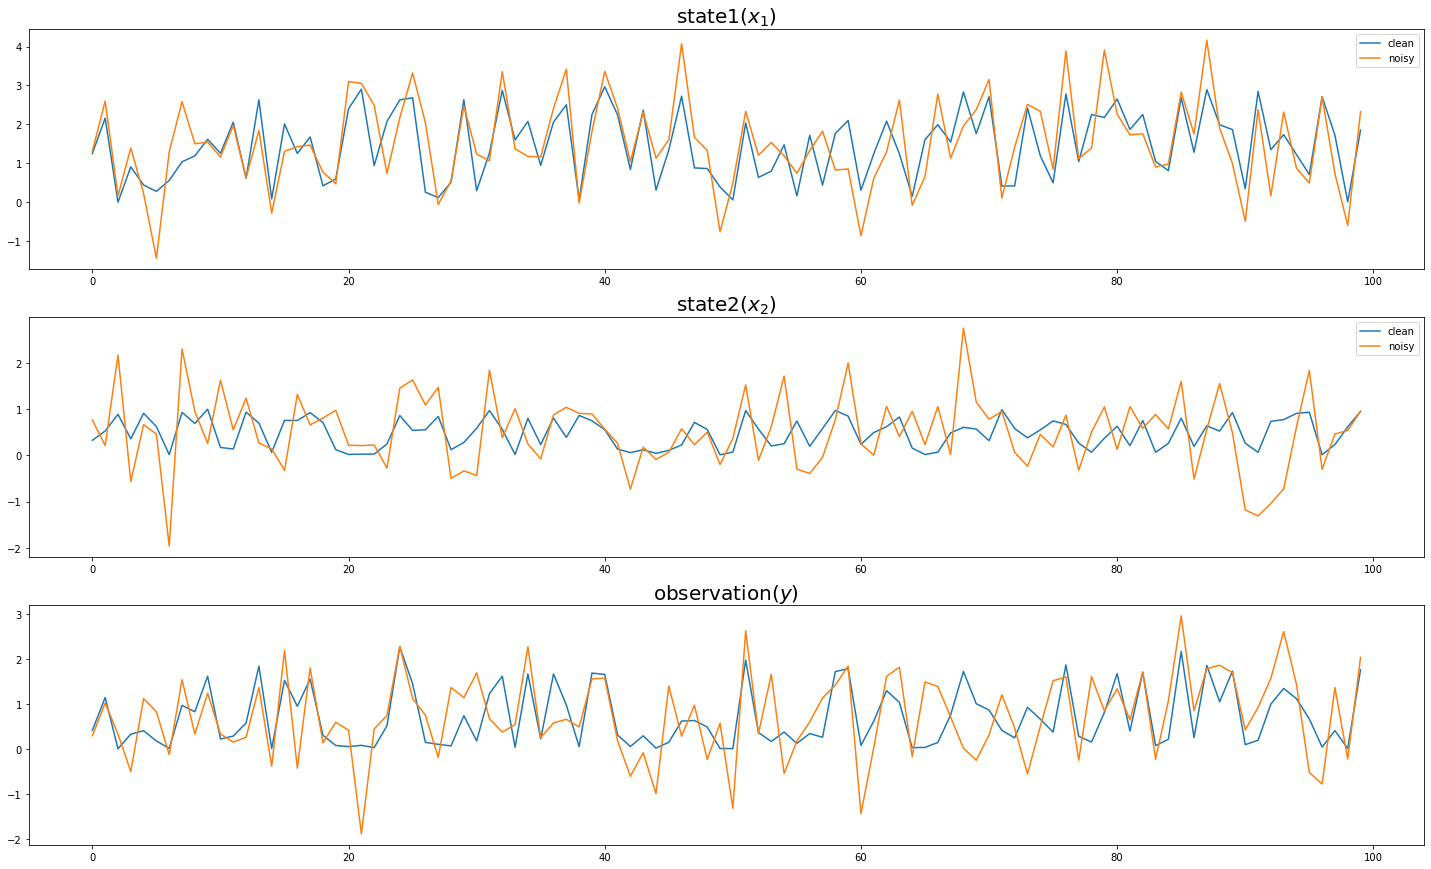

In [2]:
n = 100
x1_clean = np.random.rand(n,) * 3
x2_clean = np.random.rand(n,)
# state: x1,x2 considered to come from two different sensors, thus with uncorrelated white-noise.
x1_noisy = np.array([np.random.normal(i,np.sqrt(0.5),1) for i in x1_clean]) 
x2_noisy = np.array([np.random.normal(i,np.sqrt(0.5),1) for i in x2_clean])
# observation: non-linear (multiplicative) relationship between x1,x2
y_clean = np.multiply(x1_clean,x2_clean)
y_noisy = np.array([np.random.normal(i,np.sqrt(0.5),1) for i in y_clean])

fig=plt.figure(figsize=(25,15))

ax1=fig.add_subplot(311)
ax1.plot(x1_clean,label='clean')
ax1.plot(x1_noisy,label='noisy')
ax1.legend()
ax1.set_title('state1'+r'$(x_1)$',size=20)

ax2=fig.add_subplot(312)
ax2.plot(x2_clean,label='clean')
ax2.plot(x2_noisy,label='noisy')
ax2.legend()
ax2.set_title('state2'+r'$(x_2)$',size=20)

ax3=fig.add_subplot(313)
ax3.plot(y_clean,label='clean')
ax3.plot(y_noisy,label='noisy')
ax3.set_title('observation'+r'$(y)$',size=20)

# package data
state_noisy = np.array([x1_noisy.ravel(),x2_noisy.ravel()]).T
obs_noisy = np.array([x2_noisy.ravel(),y_noisy.ravel()]).T

## UKF

----

Extended Kalman filter(EKF) and UKF both exist to utilize Kalman filters in cases where model dynamics include nonlinearity. We already know that Gaussians are 'closed' (loosely used term here) under addition. But multiplication and division are not possible to just do so analytically on the surface. EKF gets around this by computing first or second order approximation of the dynamic (first-order EKF, second-order EKF, respectively).

But comes in the issue. EKF works only as good as the approximation itself. A strong nonlinearity will make EKF's job that much harder and may lead to divergence. A difficulty exists for the user as well, where the user has to compute and code the Jacobian of the Taylor expansion for all transitions.

UKF gets around this by using a selected points that are used to describe a distribution the random variable occupies. UKF implemented from van der Merwe is especailly great since it uses minimal number of points that are quite capable of describing large nonlinearities.

For further info, references can be found in the README.md file in the top directory.

In [3]:
from KF.UKF import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints

In [4]:
# initialize object
# initial conditions are not built in s.t. the user can decide to either;
# case[1] : directly use z0,P0 as previous updated z0,P0
# case[2] : use z0,P0 as the current time prediction of state
# Here, case[1] is being used.
UKF = UnscentedKalmanFilter(
    dim_z       =   2,
    dim_x       =   2,
    z0          =   state_noisy[0,:],
    P0          =   np.eye(2),
    fx          =   lambda x: x,
    hx          =   lambda x: np.array([x[0]*x[1],x[1]]),
    points_fn   =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    ),
    Q           =   np.eye(2),
    R           =   np.eye(2),
)
# run UKF
zs = np.empty([n,2])
Ps = np.empty([n,2,2])
innovations = np.empty([n,2])
log_likelihoods = np.empty(n)

for i in range(n):
    UKF.predict()
    UKF.update(obs_noisy[i,:])
    UKF.post_update()
    zs[i,:]=UKF.z_c_c
    Ps[i,:,:]=UKF.Pzz_c_c
    innovations[i]=UKF.innovation
    log_likelihoods[i]=UKF.log_likelihood

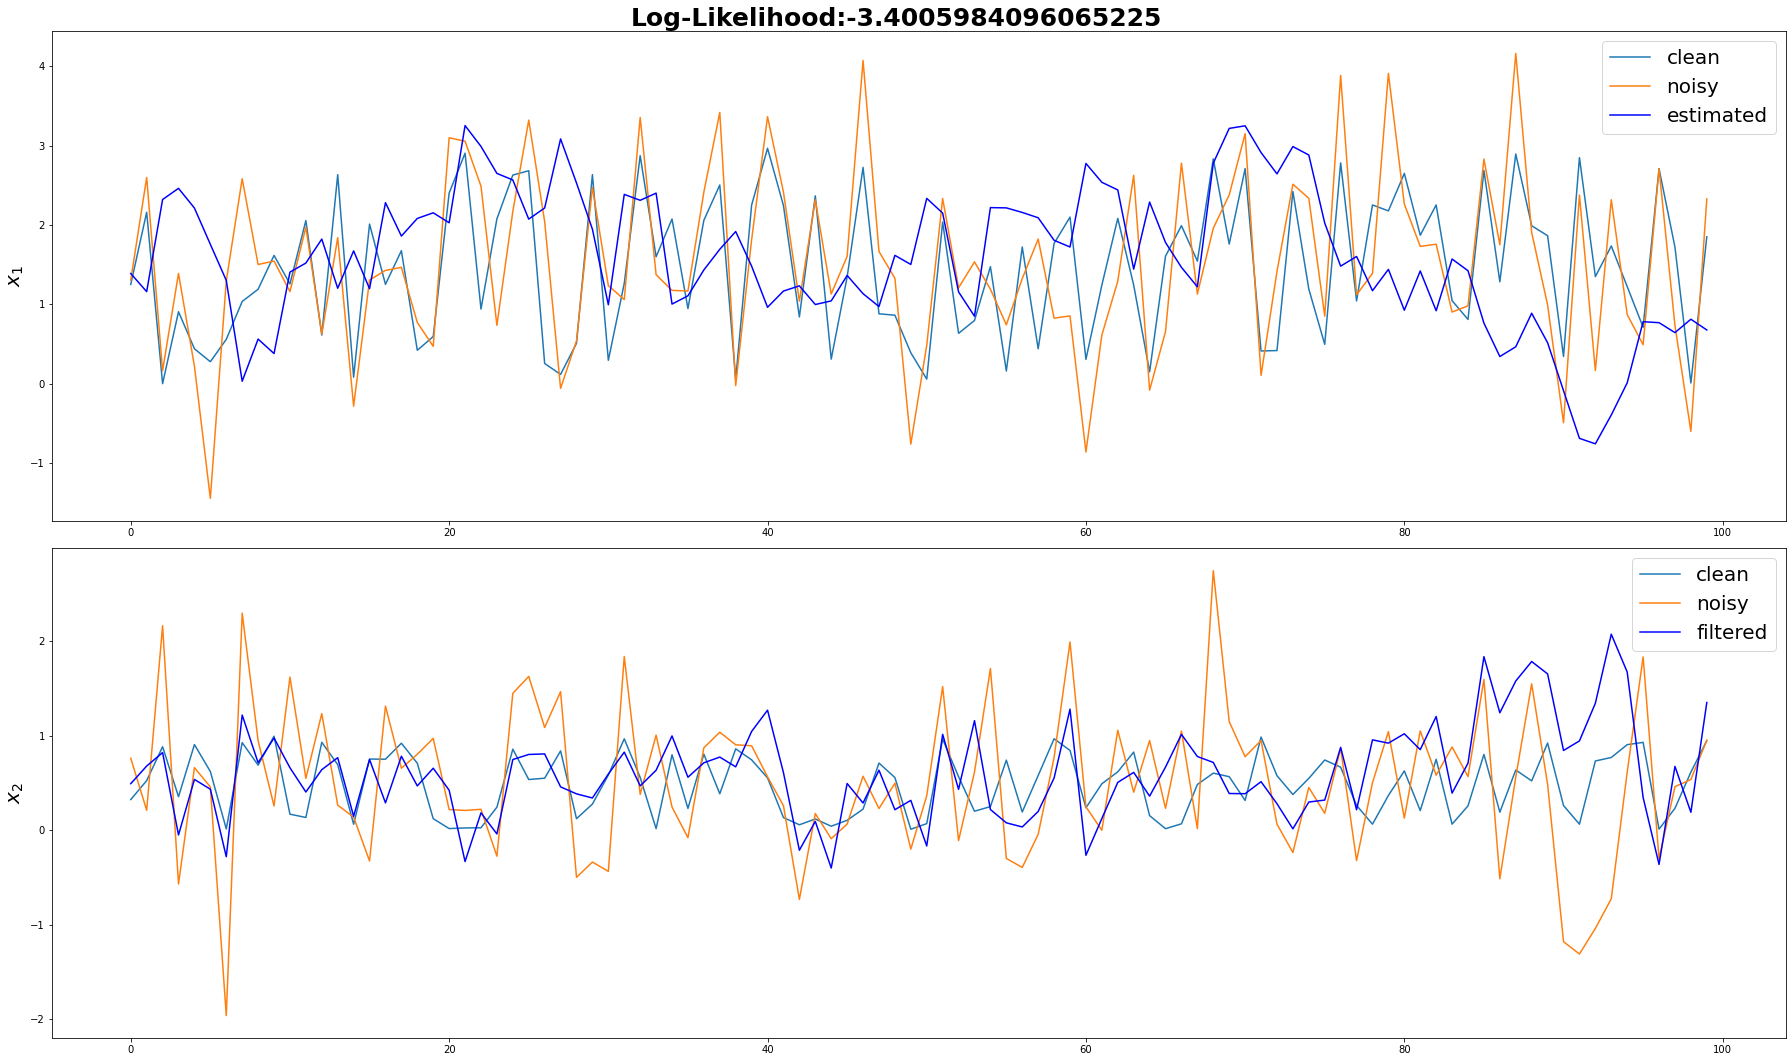

In [5]:
fig=plt.figure(figsize=(25,15))
fig.suptitle('Log-Likelihood:{}'.format(np.mean(log_likelihoods)),size=25,weight='bold')
# estimated x1
ax1=fig.add_subplot(211)
ax1.plot(x1_clean,label='clean')
ax1.plot(x1_noisy,label='noisy')
ax1.plot(zs[:,0],label='estimated',color ='b',lw=1.5)
ax1.set_ylabel(r'$x_1$',size=20,weight='bold')
ax1.legend(fontsize=20)
# filtered x2
ax2=fig.add_subplot(212)
ax2.plot(x2_clean,label='clean')
ax2.plot(x2_noisy,label='noisy')
ax2.plot(zs[:,1],label='filtered',color='b',lw=1.5)
ax2.set_ylabel(r'$x_2$',size=20,weight='bold')
ax2.legend(fontsize=20)
fig.tight_layout()

# AUKF - Adaptive Measurement Noise

Kalman filters can be finicky; depending on the initial conditions and noise variances used for transition ($Q$) or measurement ($R$), the filter can diverge away to infinity<sup>3</sup>.

For transition and measurement noise, it's tricky. Larger transition noise will make the filter sensitive to changes in value, at the cost of incorporating noise (fluctuations to the estimation). Larger measurement noise will allow the filter to stay within the vicinity, but too large the filter will diverge away.

<br>

A different approach is to make either of the noise variances fluctuate in time. A popular approach is in adaptive measurement noise, which may be applicable to sensor noises that change in time are uncertain from the beginning. For changing sensor noise, AUKF will ensure its R also changes in time as well. For an uncertain value of $R$, AUKF will slowly adjust to a value required for the filter such that it does not diverge.

[3] Literally, the log-likelihood will show negative infinite value.

In [6]:
from KF.AUKF import adaptiveUKF

In [7]:
# initialize object
AUKF = adaptiveUKF(
    n           =   n,
    delta       =   0.7,
    dim_z       =   2,
    dim_x       =   2,
    z0          =   state_noisy[0,:],
    P0          =   np.eye(2),
    fx          =   lambda x: x,
    hx          =   lambda x: np.array([x[0]*x[1],x[1]]),
    points_fn   =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    ),
    Q           =   np.eye(2),
    R           =   np.eye(2)
)
# run AUKF
zs = np.empty([n,2])
Ps = np.empty([n,2,2])
Rs = np.empty([n,2,2])
innovations = np.empty([n,2])
log_likelihoods = np.empty(n)
for i in range(n):
    AUKF.predict()
    AUKF.update(obs_noisy[i,:])
    AUKF.post_update()
    # adapt measurement-noise
    AUKF.adapt_R(i,obs_noisy[i,:])
    zs[i,:]=AUKF.z_c_c
    Ps[i,:,:]=AUKF.Pzz_c_c
    Rs[i,:,:]=AUKF.R
    innovations[i]=AUKF.innovation
    log_likelihoods[i]=AUKF.log_likelihood

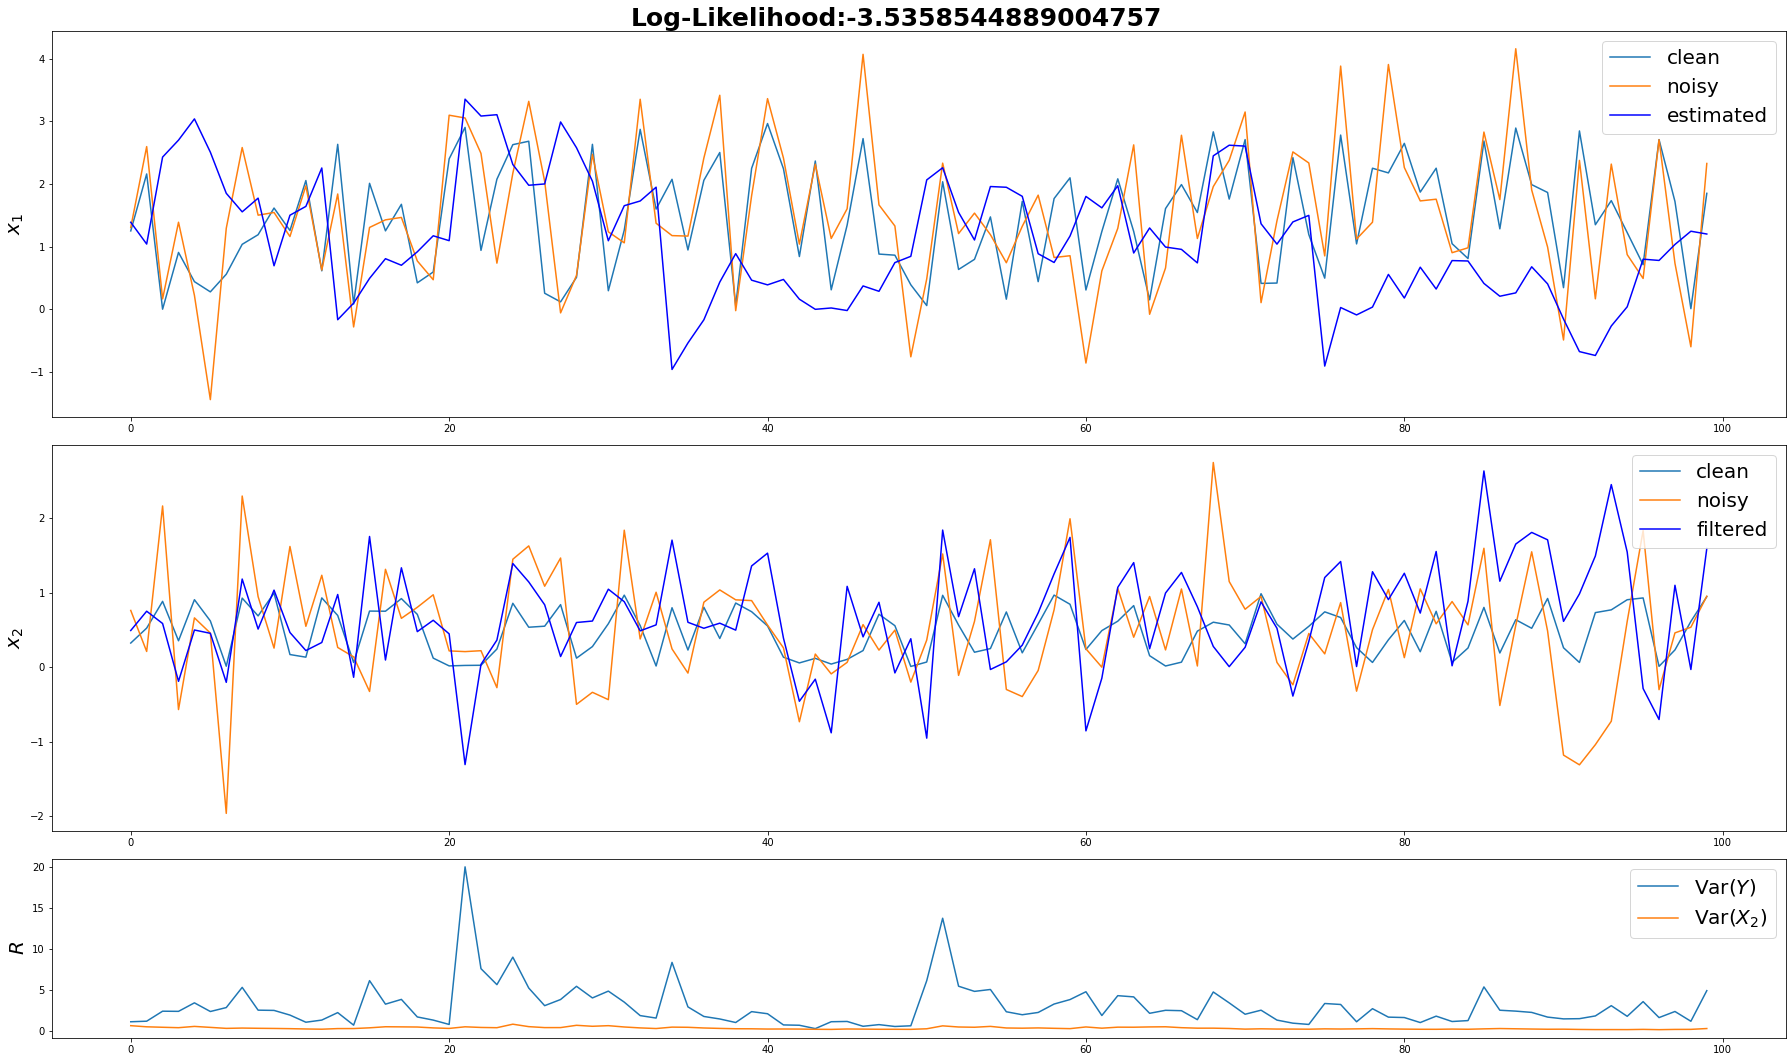

In [8]:
fig=plt.figure(figsize=(25,15))
grid = gridspec.GridSpec(nrows=5,ncols=1,figure=fig)
fig.suptitle('Log-Likelihood:{}'.format(np.mean(log_likelihoods)),size=25,weight='bold')
# estimated x1
ax1=fig.add_subplot(grid[0:2,0])
ax1.plot(x1_clean,label='clean')
ax1.plot(x1_noisy,label='noisy')
ax1.plot(zs[:,0],label='estimated',color='b',lw=1.5)
ax1.set_ylabel(r'$x_1$',size=20,weight='bold')
ax1.legend(loc='upper right',fontsize=20)
# filtered x2
ax2=fig.add_subplot(grid[2:4,0])
ax2.plot(x2_clean,label='clean')
ax2.plot(x2_noisy,label='noisy')
ax2.plot(zs[:,1],label='filtered',color='b',lw=1.5)
ax2.set_ylabel(r'$x_2$',size=20,weight='bold')
ax2.legend(loc='upper right',fontsize=20)
# Measurement noise
ax3=fig.add_subplot(grid[4,0])
ax3.plot(Rs[:,0,0],label='Var'+r'$(Y)$')
ax3.plot(Rs[:,1,1],label='Var'+r'$(X_2)$')
ax3.set_ylabel(r'$R$',size=20,weight='bold')
ax3.legend(loc='upper right',fontsize=20)
fig.tight_layout()

# AUKF - Adaptive Transition/Measurement Noise #1

Then what if we were to adapt both Q and R? Below is an implementation of Zheng et al. (2018, Sensors) who have implemented a sort of fault-detection AUKF which adapts Q,R based on chi-squared statistic computed at every iteration. If threshold is met and breached, adaptation of both Q and R ensues and the state mean and variance are recomputed at the same time point.

Note that the recompute of state mean and variance at the same iteration is a feature here. But it also makes computation longer (double the computational load due to having to compute the same process twice in succession for every iteration if threshold is met).


In [9]:
from KF.Zheng_AUKF import adaptiveUKF as ZhengAUKF

In [10]:
# initialize object
del AUKF # delete the previous AUKF object from the variables
AUKF = ZhengAUKF(
    dim_z       =   2,
    dim_x       =   2,
    z0          =   state_noisy[0,:],
    P0          =   np.eye(2),
    fx          =   lambda x: x,
    hx          =   lambda x: np.array([x[0]*x[1],x[1]]),
    points_fn   =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    ),
    Q           =   np.eye(2),
    R           =   np.eye(2),
    chi_sq_threshold = 0.3
)
# run AUKF
zs = np.empty([n,2])
Ps = np.empty([n,2,2])
Qs = np.empty([n,2,2])
Rs = np.empty([n,2,2])
innovations = np.empty([n,2])
log_likelihoods = np.empty(n)
for i in range(n):
    # run
    AUKF.predict()
    AUKF.update(obs_noisy[i,:])
    AUKF.adapt_QR(obs_noisy[i,:])
    # extract
    zs[i,:]=AUKF.z_c_c
    Ps[i,:,:]=AUKF.Pzz_c_c
    Qs[i,:,:]=AUKF.Q
    Rs[i,:,:]=AUKF.R
    innovations[i]=AUKF.innovation
    log_likelihoods[i]=AUKF.log_likelihood

Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi threshold reached.
Psi thresho

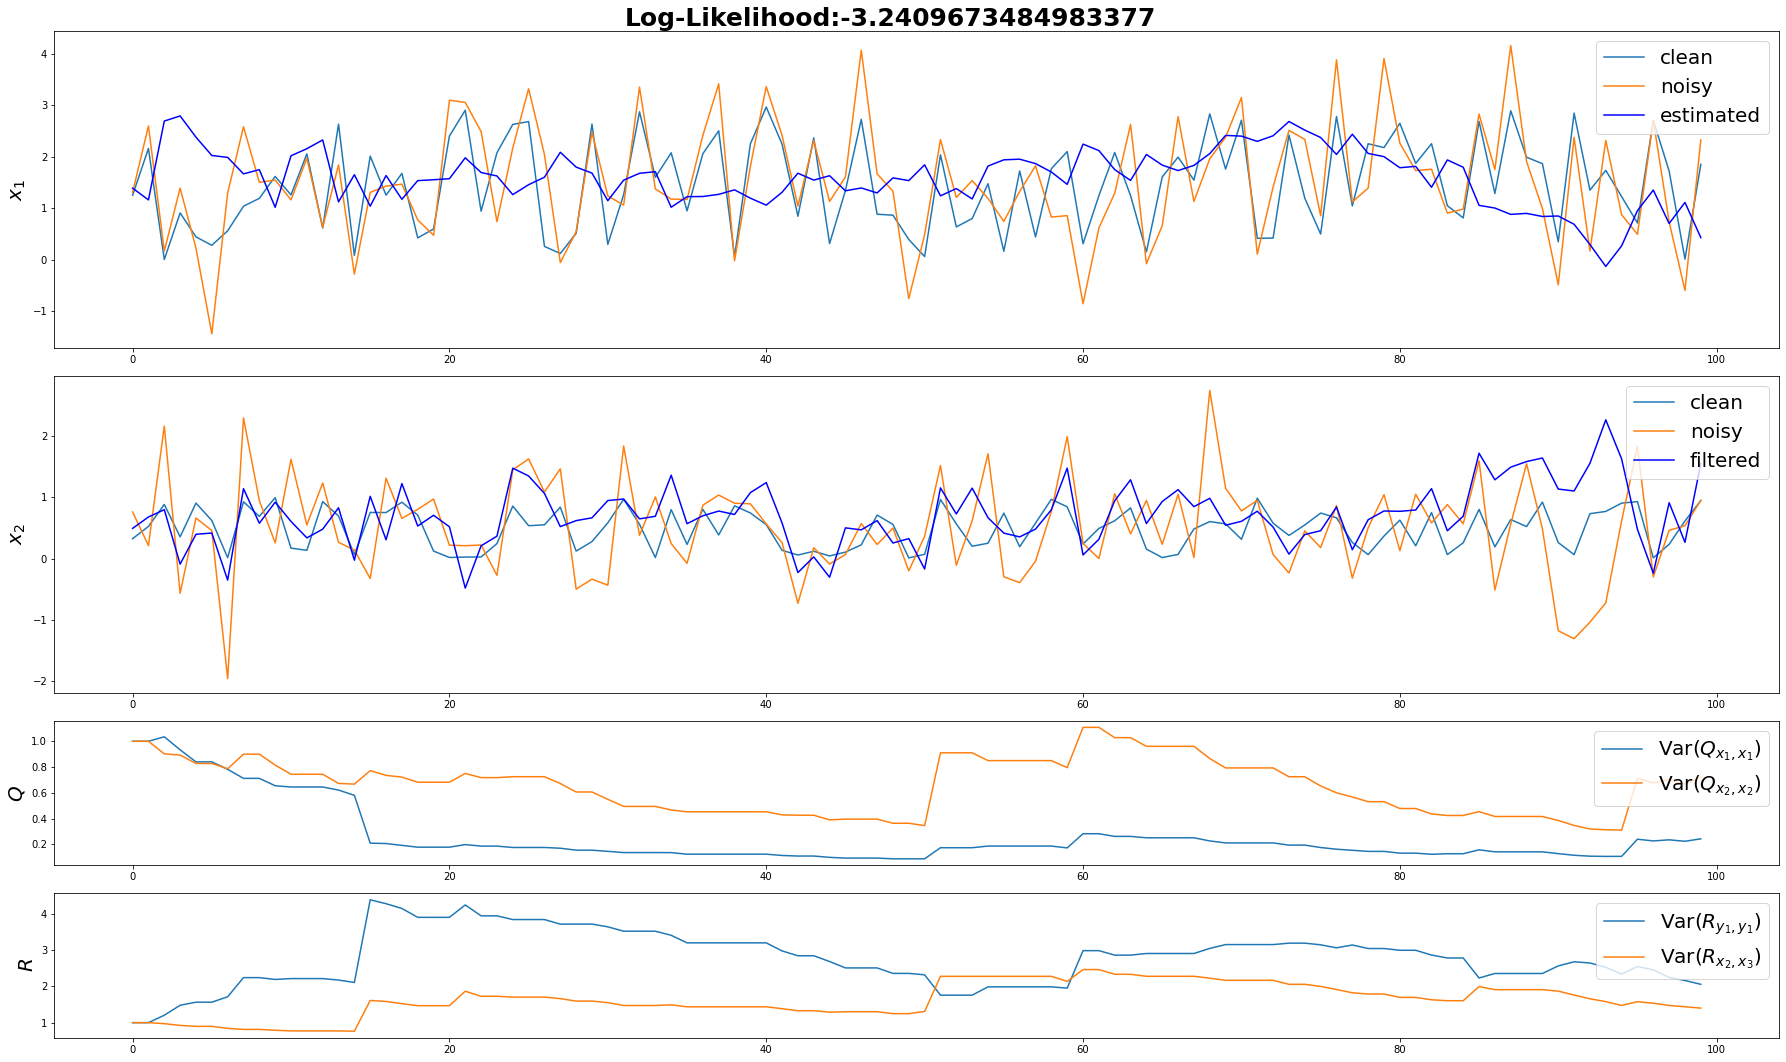

In [11]:
fig=plt.figure(figsize=(25,15))
grid = gridspec.GridSpec(nrows=6,ncols=1,figure=fig)
fig.suptitle('Log-Likelihood:{}'.format(np.mean(log_likelihoods)),size=25,weight='bold')
# estimated x1
ax1=fig.add_subplot(grid[0:2,0])
ax1.plot(x1_clean,label='clean')
ax1.plot(x1_noisy,label='noisy')
ax1.plot(zs[:,0],label='estimated',color='b',lw=1.5)
ax1.set_ylabel(r'$x_1$',size=20,weight='bold')
ax1.legend(loc='upper right',fontsize=20)
# filtered x2
ax2=fig.add_subplot(grid[2:4,0])
ax2.plot(x2_clean,label='clean')
ax2.plot(x2_noisy,label='noisy')
ax2.plot(zs[:,1],label='filtered',color='b',lw=1.5)
ax2.set_ylabel(r'$x_2$',size=20,weight='bold')
ax2.legend(loc='upper right',fontsize=20)
# Transition noise (Q)
ax3=fig.add_subplot(grid[4,0])
ax3.plot(Qs[:,0,0],label='Var'+r'$(Q_{x_1,x_1})$')
ax3.plot(Qs[:,1,1],label='Var'+r'$(Q_{x_2,x_2})$')
ax3.set_ylabel(r'$Q$',size=20,weight='bold')
ax3.legend(loc='upper right',fontsize=20)
# Measurement noise (R)
ax4=fig.add_subplot(grid[5,0])
ax4.plot(Rs[:,0,0],label='Var'+r'$(R_{y_1,y_1})$')
ax4.plot(Rs[:,1,1],label='Var'+r'$(R_{x_2,x_3})$')
ax4.set_ylabel(r'$R$',size=20,weight='bold')
ax4.legend(loc='upper right',fontsize=20)
fig.tight_layout()

Note that chi_sqr threshold was set to be quite low, as in reliability is high. But it forces virtually all iterations to adapt Q and R.

# AUKF - Adaptive Transition/Measurement Noise #2

Here is an another implementation by Zhang (2009, IEEE). The idea behind this implementation is that filters that deal with large nonlinearities will require a counterweight to ensure the filter doesn't diverge. A similar idea is found for canonical filters with 'fading memory' concept. This is a similar line of thought but for Q and R as well.

In [12]:
from KF.Zhang_AUKF import adaptiveUKF as ZhangAUKF

In [25]:
# initialize object
del AUKF # delete the previous AUKF object from the variables
AUKF = ZhangAUKF(
    dim_z       =   2,
    dim_x       =   2,
    z0          =   state_noisy[0,:],
    P0          =   np.eye(2),
    fx          =   lambda x: x,
    hx          =   lambda x: np.array([x[0]*x[1],x[1]]),
    points_fn   =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    ),
    Q           =   np.eye(2),
    R           =   np.eye(2),
    b           =   0.83 # forgetting scale
)
# run AUKF
zs = np.empty([n,2])
Ps = np.empty([n,2,2])
Qs = np.empty([n,2,2])
Rs = np.empty([n,2,2])
innovations = np.empty([n,2])
log_likelihoods = np.empty(n)
for i in range(n):
    try:
        # run
        AUKF.predict()
        AUKF.update(obs_noisy[i,:])
        AUKF.adapt_QR(i,obs_noisy[i,:])
        AUKF.post_update()
        #AUKF.correct_update(obs_noisy[i,:])
        # extract
        zs[i,:]=AUKF.z_c_c
        Ps[i,:,:]=AUKF.Pzz_c_c
        Qs[i,:,:]=AUKF.Q
        Rs[i,:,:]=AUKF.R
        innovations[i]=AUKF.innovation
        log_likelihoods[i]=AUKF.log_likelihood
    except:
        print('{}th iteration threw an error.'.format(i))
        print(AUKF.Q)
        print(AUKF.R)
        print(AUKF.d)
        raise

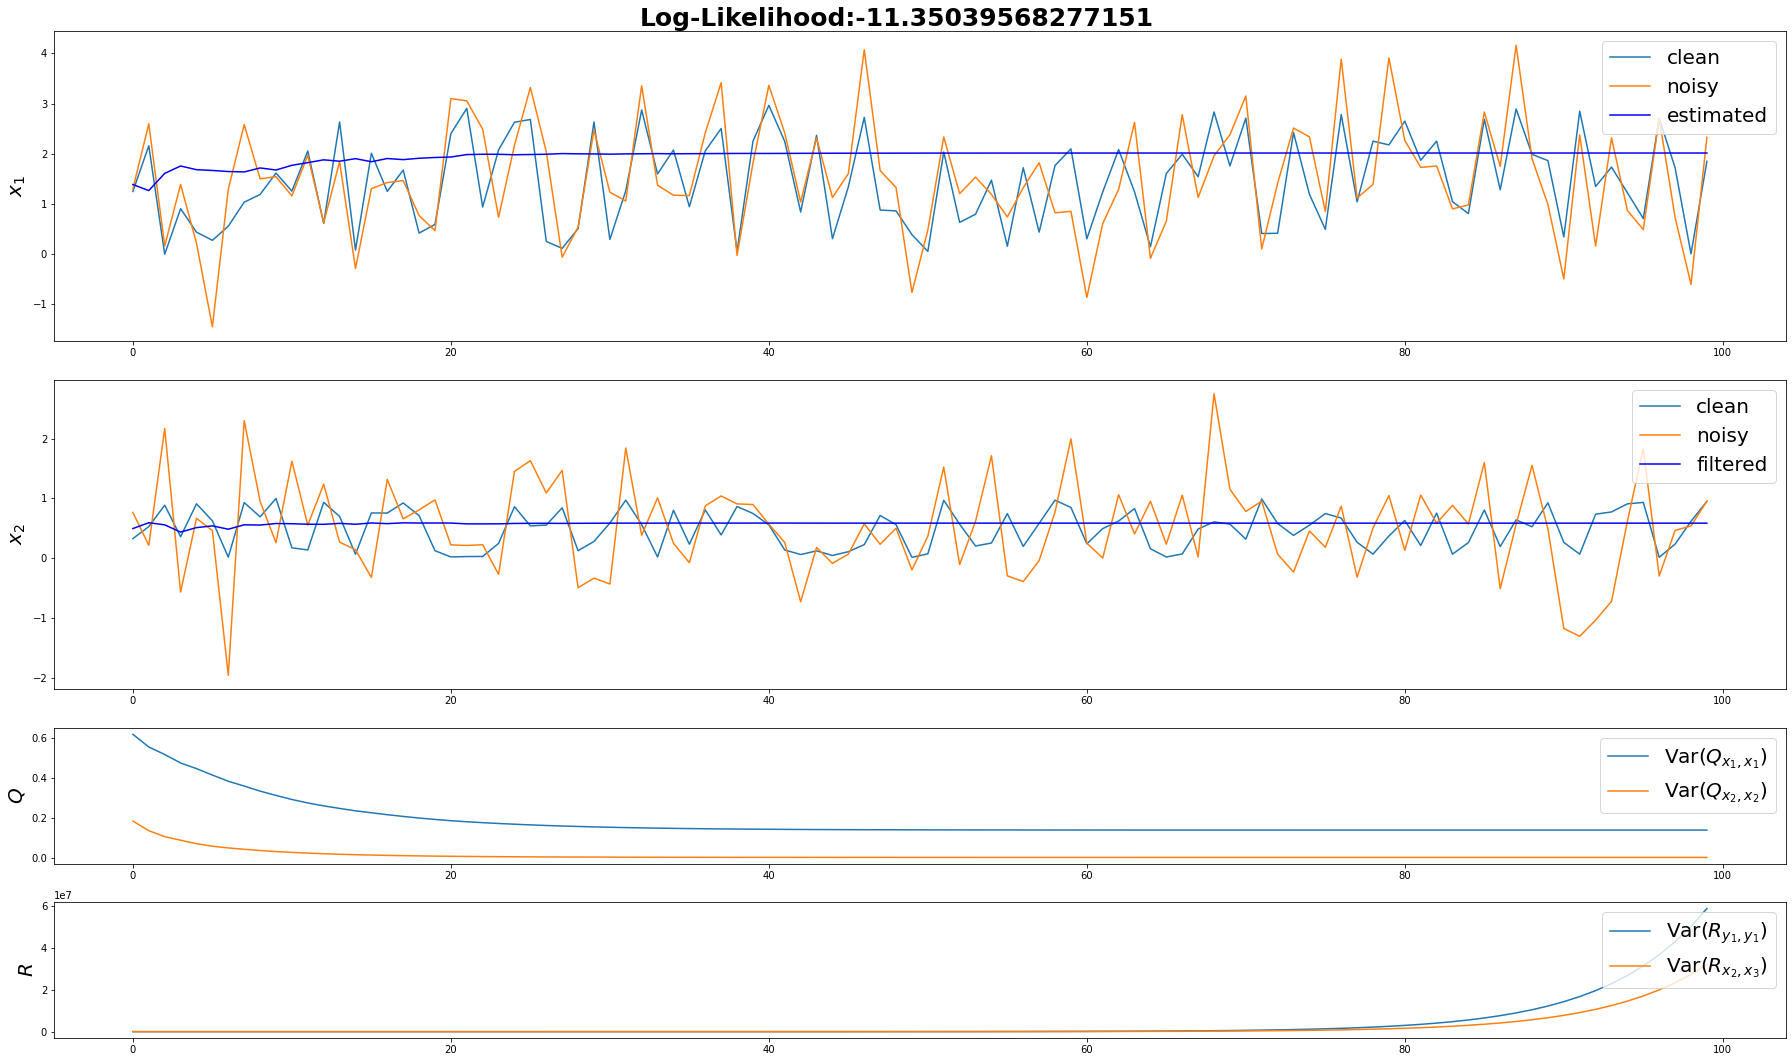

In [26]:
fig=plt.figure(figsize=(25,15))
grid = gridspec.GridSpec(nrows=6,ncols=1,figure=fig)
fig.suptitle('Log-Likelihood:{}'.format(np.mean(log_likelihoods)),size=25,weight='bold')
# estimated x1
ax1=fig.add_subplot(grid[0:2,0])
ax1.plot(x1_clean,label='clean')
ax1.plot(x1_noisy,label='noisy')
ax1.plot(zs[:,0],label='estimated',color='b',lw=1.5)
ax1.set_ylabel(r'$x_1$',size=20,weight='bold')
ax1.legend(loc='upper right',fontsize=20)
# filtered x2
ax2=fig.add_subplot(grid[2:4,0])
ax2.plot(x2_clean,label='clean')
ax2.plot(x2_noisy,label='noisy')
ax2.plot(zs[:,1],label='filtered',color='b',lw=1.5)
ax2.set_ylabel(r'$x_2$',size=20,weight='bold')
ax2.legend(loc='upper right',fontsize=20)
# Transition noise (Q)
ax3=fig.add_subplot(grid[4,0])
ax3.plot(Qs[:,0,0],label='Var'+r'$(Q_{x_1,x_1})$')
ax3.plot(Qs[:,1,1],label='Var'+r'$(Q_{x_2,x_2})$')
ax3.set_ylabel(r'$Q$',size=20,weight='bold')
ax3.legend(loc='upper right',fontsize=20)
# Measurement noise (R)
ax4=fig.add_subplot(grid[5,0])
ax4.plot(Rs[:,0,0],label='Var'+r'$(R_{y_1,y_1})$')
ax4.plot(Rs[:,1,1],label='Var'+r'$(R_{x_2,x_3})$')
ax4.set_ylabel(r'$R$',size=20,weight='bold')
ax4.legend(loc='upper right',fontsize=20)
fig.tight_layout()

... Which does not particularly yield a good result for our data. A one possibility of course is that the data they were aiming for wasn't our use case. Afterall, there isn't that much noise present in our data nor are there large nonlinearities that are not well captured through a typical EKF or UKF.

Of course, another possibility is that this implementation is in fact, wrong.